#### Objective

This project aims to precit future bike rentals

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
#!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

**Data Loading**

In [ ]:
df_day=pd.read_csv('day.csv')
df_day_ml=df_day.copy()
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01/01/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,02/01/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,03/01/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,04/01/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,05/01/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
df_hour=pd.read_csv('hour.csv')
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01/01/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01/01/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01/01/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01/01/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01/01/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


**Data Exploration**

In [ ]:
print(df_day.shape)
df_day.info()

(731, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [ ]:
print(df_hour.shape)
df_hour.info()

(17379, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
df_day.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [ ]:
df_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [ ]:
df_day.isna().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0


In [ ]:
df_hour.isna().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
hr,0
holiday,0
weekday,0
workingday,0
weathersit,0


In [ ]:
#checking duplicates
print(df_day.duplicated(['dteday']).sum())
print(df_day.duplicated(['instant']).sum())
print(df_hour.duplicated(['instant']).sum())

0
0
0


#### Data Summary & Observations

##### Day Dataset
- **Rows & Columns**: 731 rows, 16 columns.
- **Target Variable**: cnt (total bike rentals).
- **Temperature, Feels-like Temperature, Humidity& Wind Speed**: Normalized between 0 and 1
- **Season & Weather Situation**: Categorical but stored as integers.
- **cnt**: Casual and registered contribute to `cnt`, indicating a relationship.

##### Hour Dataset
- **Rows & Columns**: 17,379 rows, 17 columns.
- **Additional Feature**: hr (hour of the day) provides finer granularity.
- **Temperature, Feels-like Temperature, Humidity& Wind Speed**: Normalized between 0 and 1
- **Rental Distribution**: Higher variance in cnt due to time-based fluctuations.
- **zero rentals**: Minimum values of casual, registered, and cnt suggest some hours had zero rentals.

##### General Observations
- **No Missing Values**: Both datasets are complete.
- **Data Distribution**: Seasonal, daily, and hourly patterns should be explored.
- **Potential Feature Engineering**:
  - Convert `dteday` to date format.
  - Encode categorical variables appropriately.


**Data Preprocessing**

In [ ]:
#converting Date column data type into Date format
df_day['dteday'] = pd.to_datetime(df_day['dteday'], format="%d/%m/%Y")
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'], format="%d/%m/%Y")

In [ ]:
df_day.set_index('dteday', inplace=True)
df_day.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
#dropping unimportant columns
df_day.drop(['instant'], axis=1, inplace=True)
df_hour.drop(['instant'], axis=1, inplace=True)

In [ ]:
df_categorical_features = df_day[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]
df_numerical=df_day[['temp', 'atemp',	'hum',	'windspeed', 'casual', 'registered']]

**Exploratory Data Analysis**

**Performing Univariant Analysis**

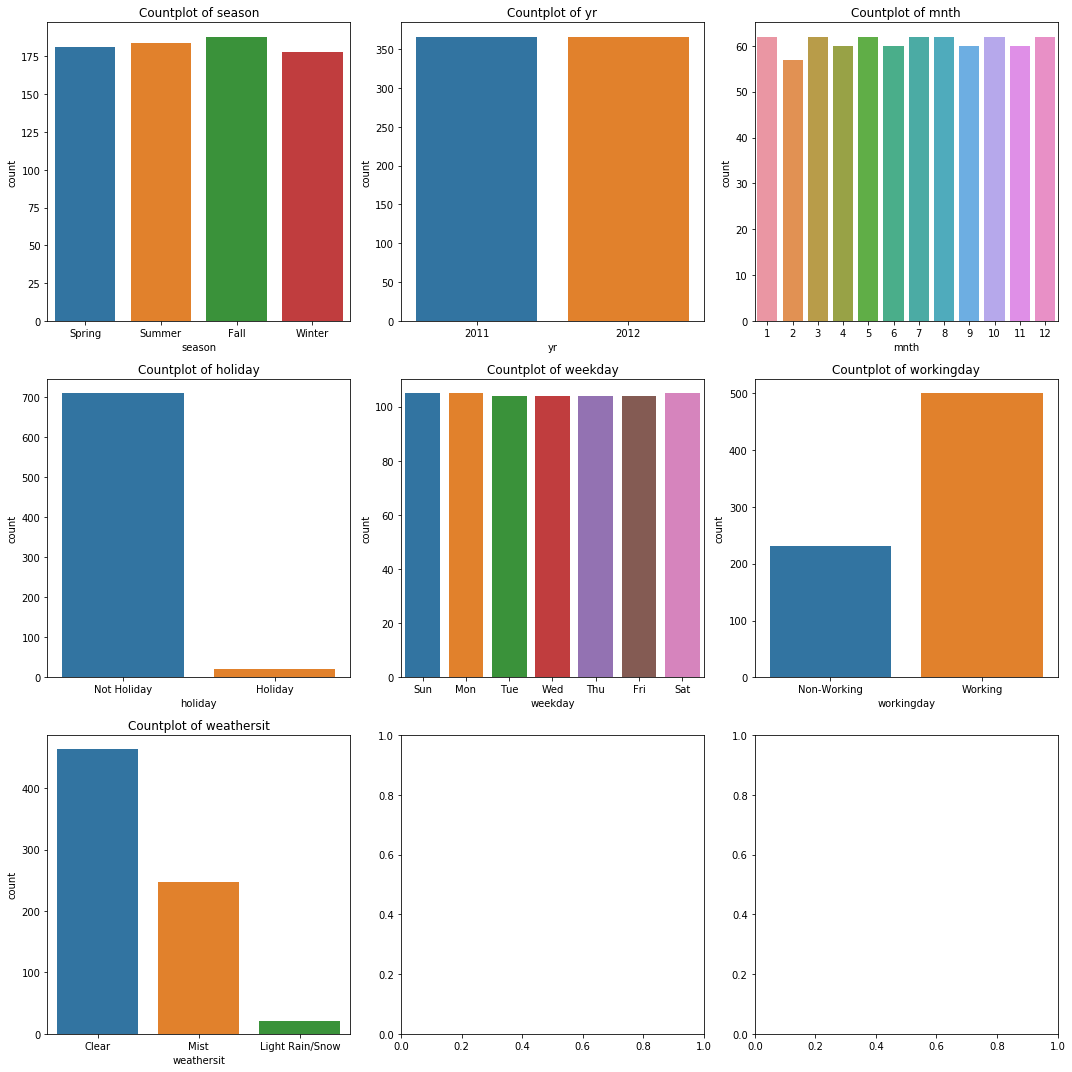

In [ ]:
modify_labels = {
    'season': ['Spring', 'Summer', 'Fall', 'Winter'],
    'yr': ['2011', '2012'],
    'holiday': ['Not Holiday', 'Holiday'],
    'weekday': ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    'workingday': ['Non-Working', 'Working'],
    'weathersit': ['Clear', 'Mist', 'Light Rain/Snow', 'Heavy Rain/Snow']
}

# Distributions of categorical features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(df_categorical_features.columns):
    sns.countplot(x=col, data=df_categorical_features, ax=axes[i])
    axes[i].set_title(f'Countplot of {col}')

    if col in modify_labels:
        axes[i].set_xticklabels(modify_labels[col])

plt.tight_layout()
plt.show()


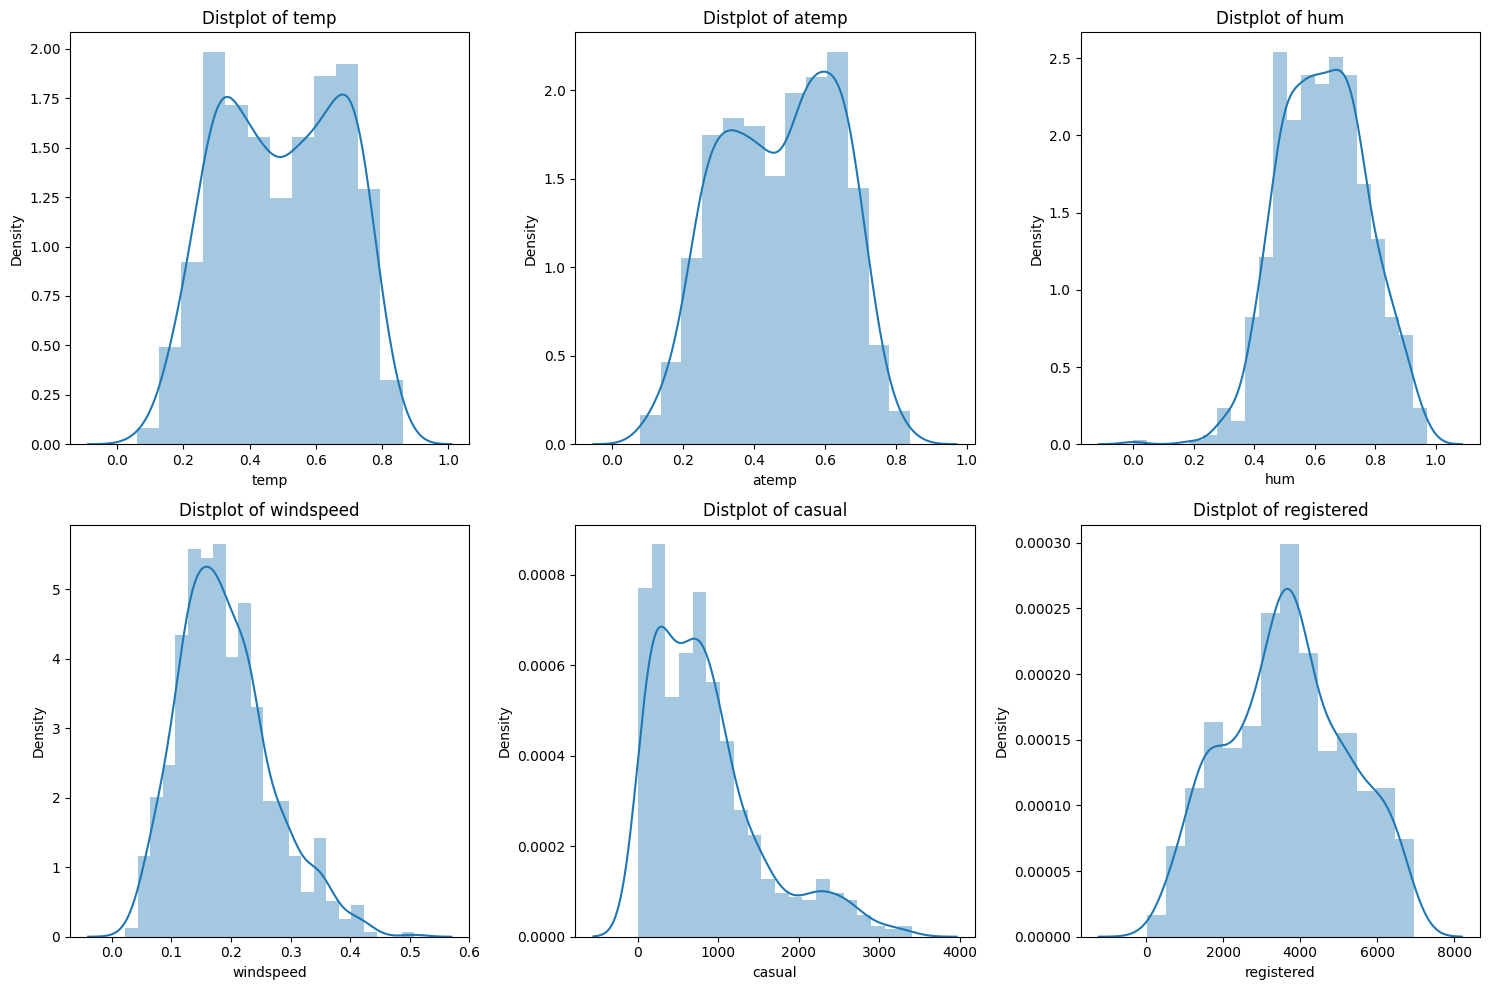

In [ ]:
# Distributions of numerical features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(df_numerical.columns):
    sns.distplot(df_numerical[col], ax=axes[i])
    axes[i].set_title(f'Distplot of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

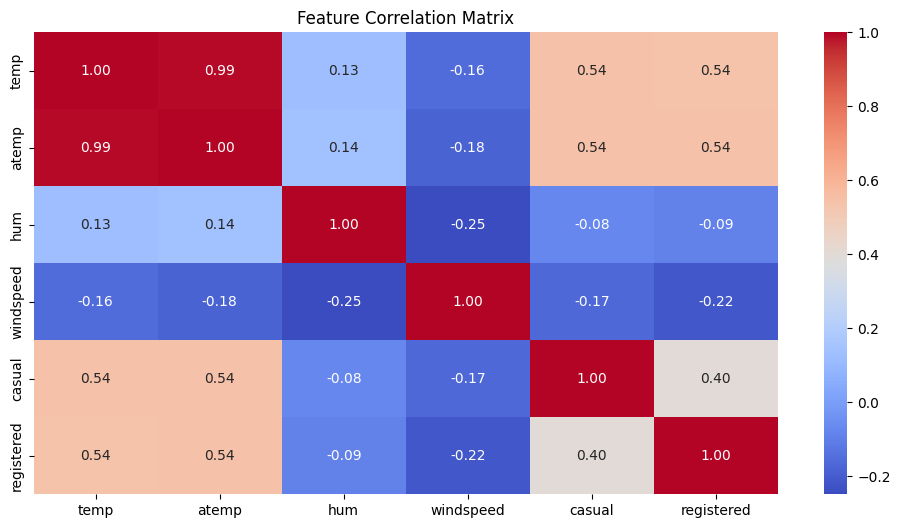

In [ ]:
# Correlation Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

**Performing Biivariant Analysis**

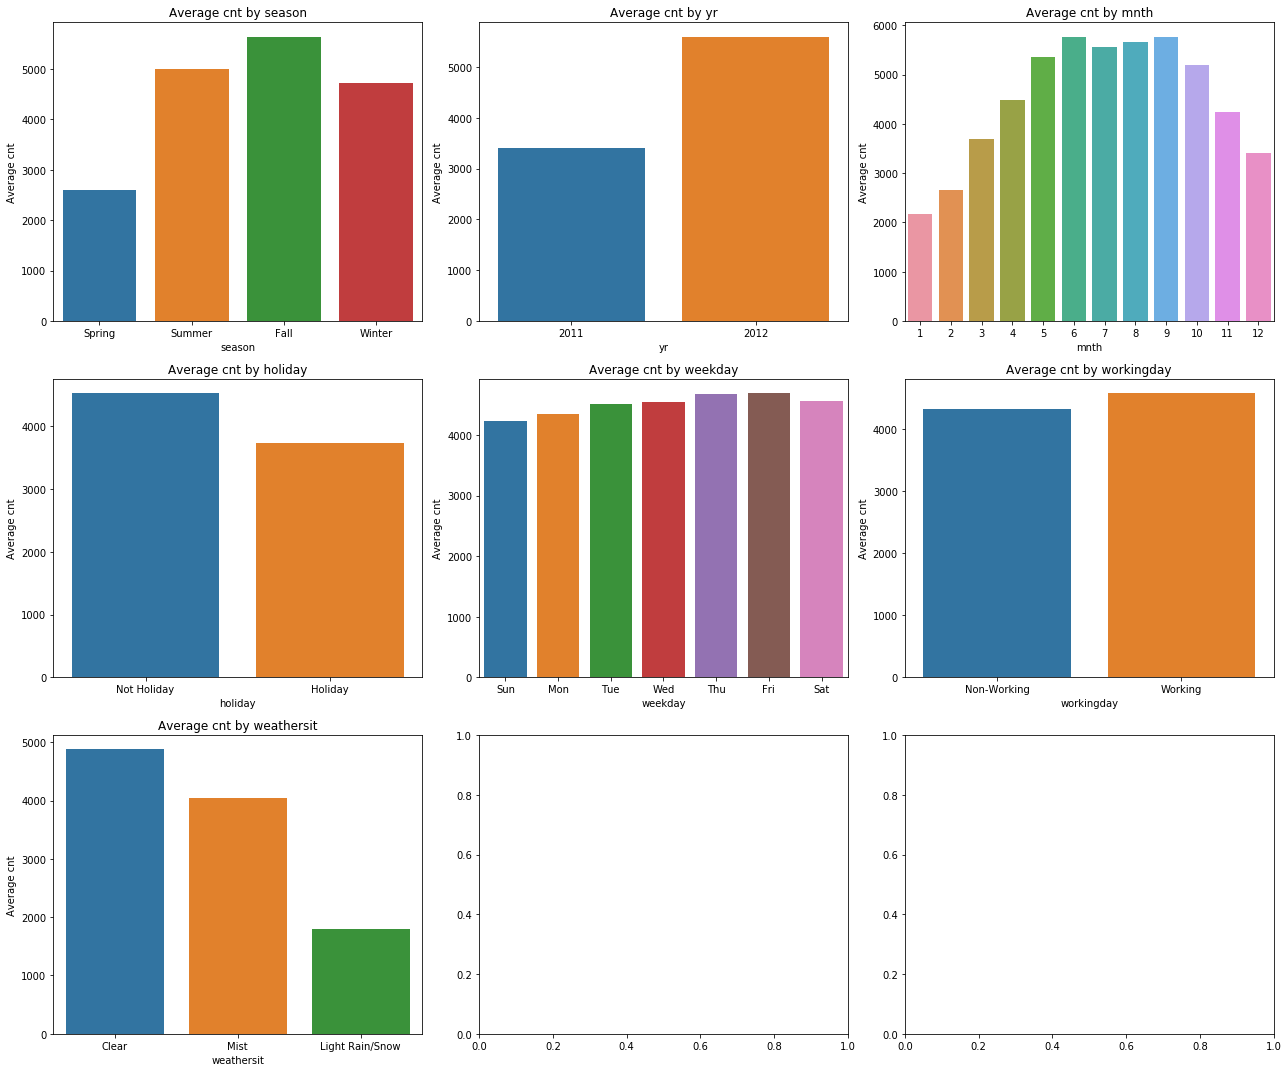

In [ ]:
#mean rentals per category,
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()
target_variable='cnt'
for i, col in enumerate(df_categorical_features.columns):
    if col in df_day.columns:
        category_means = df_day.groupby(col)[target_variable].mean().reset_index()
        sns.barplot(x=col, y=target_variable, data=category_means, ax=axes[i])
        axes[i].set_title(f'Average {target_variable} by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(f'Average {target_variable}')

        if col in modify_labels:
            axes[i].set_xticklabels(modify_labels[col])

plt.tight_layout()
plt.show()


**On Hour data**

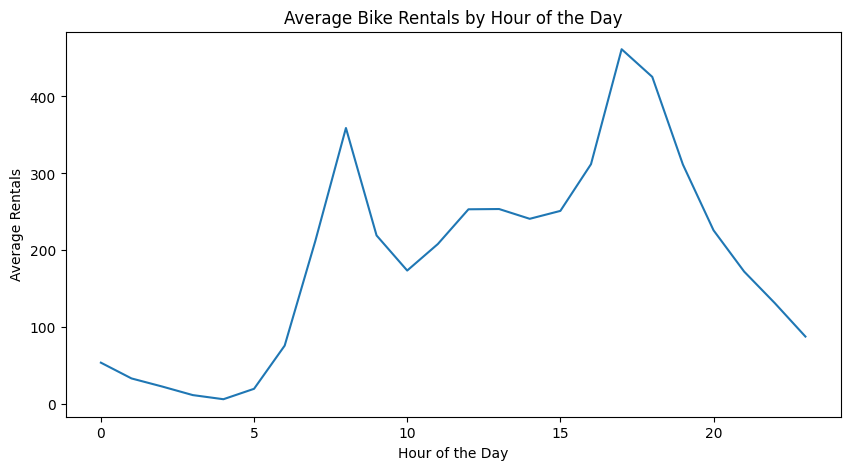

In [ ]:
# Hourly Trends over time
plt.figure(figsize=(10, 5))
sns.lineplot(x="hr", y="cnt", data=df_hour, estimator="mean", ci=None)
plt.title("Average Bike Rentals by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Rentals")
plt.show()

Some Key observations based on univariate and bivariate analysis:  

### **Univariate Analysis Observations:**  
1. **Seasonal Trends:** - Bike rentals are highest in Fall and Summer, while Winter sees a significant drop.  
2. **Yearly Comparison:** - The count of rentals increased significantly from 2011 to 2012, indicating growth in usage.  
3. **Monthly Trends:** - Rentals peak in Summer months (May - September), suggesting seasonality in demand.  
4. **Holiday Impact:** - There isn’t a major difference in bike rentals between holidays and non-holidays, indicating consistent usage.  
5. **Weekday Trends:**  - Rentals remain fairly stable across weekdays, suggesting people use bikes for daily commutes.  
6. **Working Day vs. Non-Working Day:** - Similar rental counts on working and non-working days indicate a mix of both commuting and leisure biking.  
7. **Weather Conditions:** - Rentals drop significantly on rainy or snowy days, showing a clear impact of bad weather on bike usage.  
8. **Hourly Rentals:**  - Two clear peaks are visible at 8 AM and 5-6 PM, indicating heavy usage during commute hours.  

### **Bivariate Analysis Observations:**  
1. **Correlation Matrix:**
   - Temperature and rentals have a strong positive correlation (warmer days see more rentals).  
   - Humidity and windspeed have weak correlations with bike rentals.  
   - Registered users and casual users have a moderate correlation with temperature.  
2. **Distribution of Variables:**  
   - Temperature and humidity follow a normal distribution.  
   - Casual and registered user distributions indicate higher registered user counts.  

### Observations for modelling  
- **Humidity and windspeed** show very weak correlations with bike rentals, so they may not be strong predictors.  
- **Holiday vs. non-holiday** doesn’t show a significant impact, so it might not be a critical factor.  

**Time series analysis**

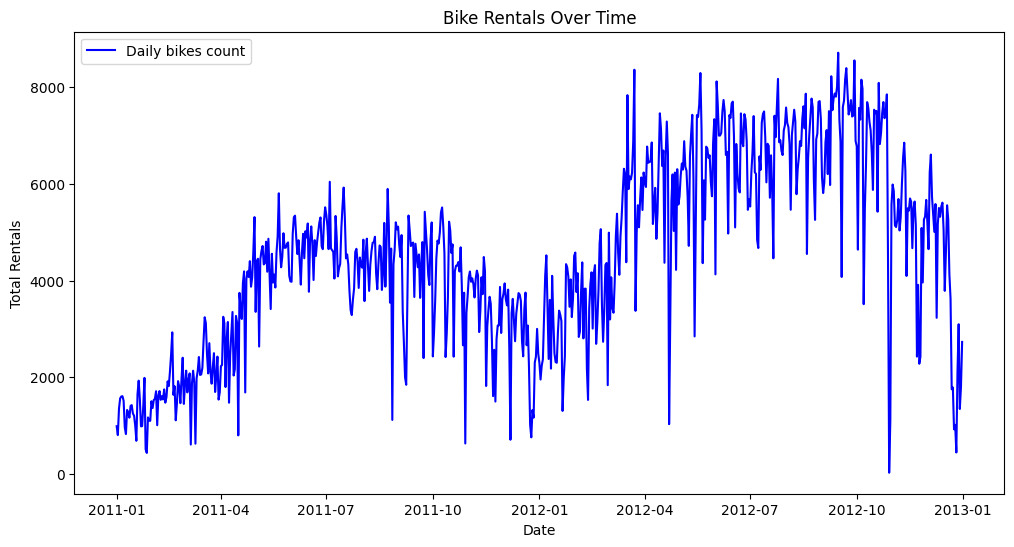

In [ ]:
# Daily total rental bikes over time
plt.figure(figsize=(12, 6))
plt.plot(df_day.index, df_day['cnt'], label="Daily bikes count", color="blue")
plt.xlabel("Date")
plt.ylabel("Total Rentals")
plt.title("Bike Rentals Over Time")
plt.legend()
plt.show()

**Time Series Decomposition**

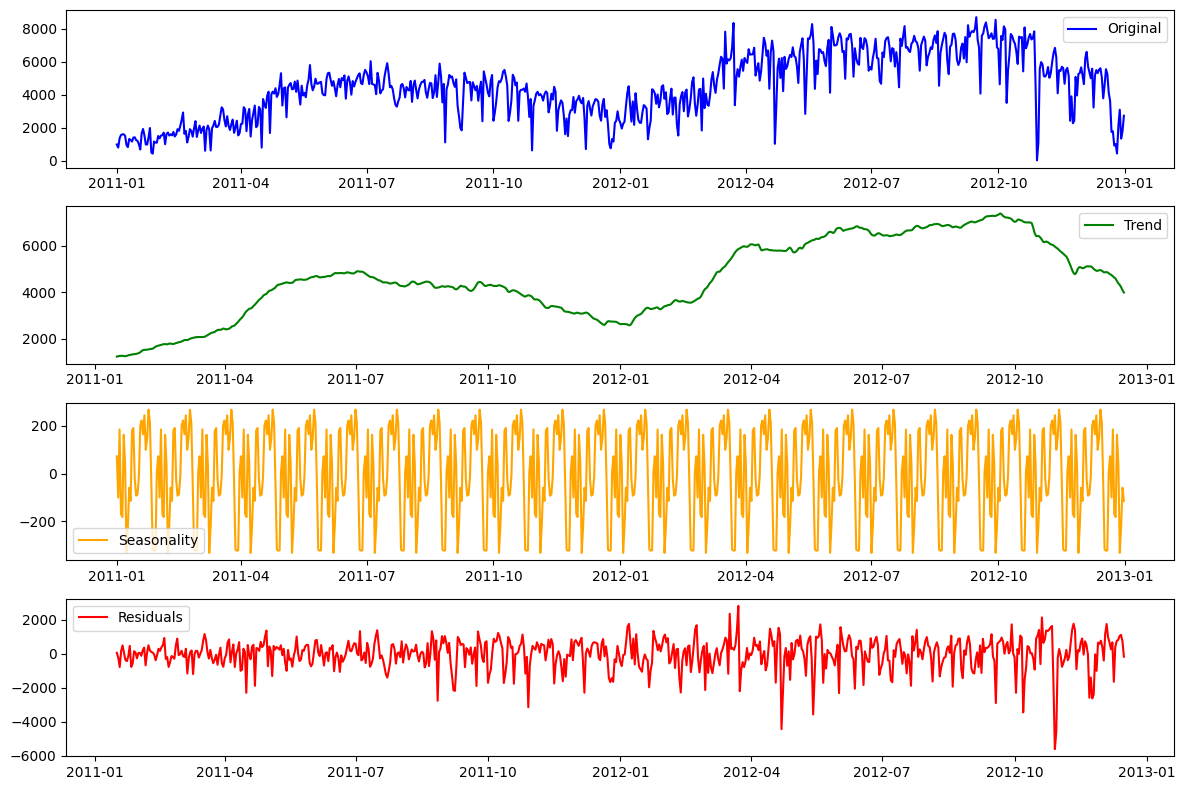

In [ ]:
#Decomposing time series into Trend, Seasonality, and Residuals
decomposition = seasonal_decompose(df_day['cnt'], model='additive', period=30)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_day['cnt'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


**Performing ADF test to check whether data is stationary or not**

In [ ]:
adf_test = adfuller(df_day['cnt'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] < 0.05:
    print("p-value is lessthan 0.05. Data is stationary (Reject H₀)")
else:
    print("p-value is greaterthan 0.05. Data is NOT stationary (Fail to reject H₀)")

ADF Statistic: -1.8774481444374296
p-value: 0.34274344033921944
p-value is greaterthan 0.05. Data is NOT stationary (Fail to reject H₀)


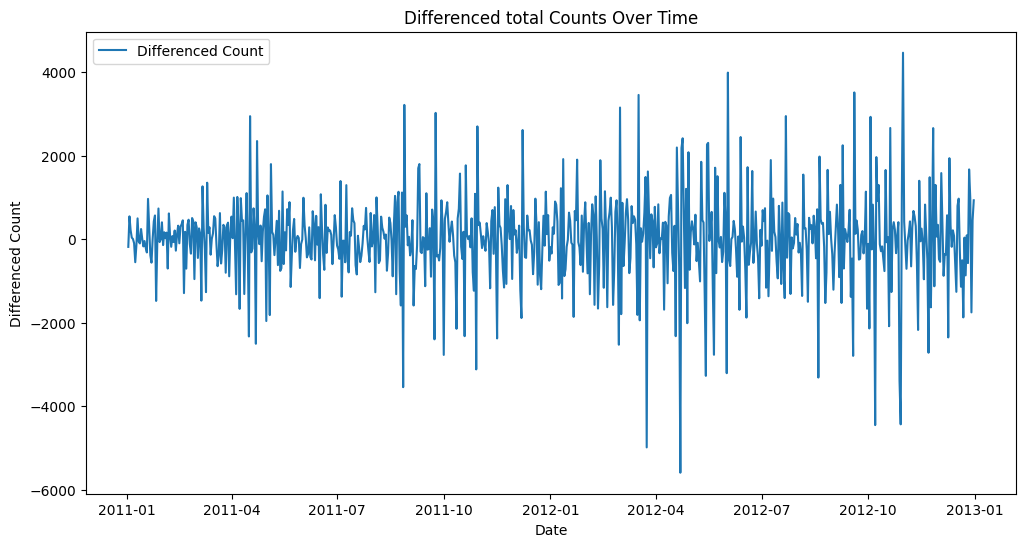

In [ ]:
# Differencing the data to make it stationary
diff_data = df_day['cnt'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(diff_data, label='Differenced Count')
plt.xlabel('Date')
plt.ylabel('Differenced Count')
plt.title('Differenced total Counts Over Time')
plt.legend()
plt.show()


**Observations:**  
- **Trend:** Bike rentals show a steady increase from early 2011 to mid-2012, followed by a slight decline.  
- **Seasonality:** Clear recurring patterns, likely influenced by weather and commuting habits.  
- **Differencing:** Helps remove trend, making data more stationary for time series modeling.  
- **Decomposition:**  
  - **Trend:** Confirms long-term growth with a peak in mid-2012.  
  - **Seasonality:** Strong cyclical patterns observed.  
  - **Residuals:** Mostly centered around zero, indicating good model fit.  

**Modelling**

In [ ]:
#Selecting Features and Target Variable
X = df_day_ml.drop(["cnt", "dteday", "casual", "registered"], axis=1)
y = df_day_ml["cnt"]

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(584, 12)
(147, 12)


In [ ]:
#Liner Regression
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


RMSE: 824.2297549517821
R² Score: 0.8305798923619114


In [ ]:
#Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


RMSE: 707.1098851716634
R² Score: 0.8753069657104284


In [ ]:
XG_model = xgb.XGBRegressor()

XG_model.fit(X_train, y_train)

y_pred_XG = XG_model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred_XG))
r2 = r2_score(y_test, y_pred_XG)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 676.0665647700675
R² Score: 0.8860151171684265


**Observations:**
- Linear Regression performs the worst among the three models, indicating that the relationship between features and bike rentals is non-linear.
- Random Forest Regressor improves performance significantly, capturing non-linear patterns better than linear regression.
- XGBoost Regressor provides the best results with the lowest RMSE (676.07) and highest R² Score (0.88), indicating strong predictive power.